In [1]:
#import the module
import sys
sys.path.append(r'C:\Users\user\Desktop\Kifiya\Bati_Bank_Credit_Scoring\scripts')
import eda_analysis as eda

In [2]:
file_path = r'C:\Users\user\Desktop\Kifiya\Bati_Bank_Credit_Scoring\data\featured_data.csv'
data = eda.data_loader(file_path)
data.head(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,...,transaction_month,transaction_year,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,256,ProviderId_6,ProductId_10,ChannelId_3,0.092004,...,11,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,256,ProviderId_4,ProductId_6,ChannelId_2,0.091910,...,11,2018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,256,ProviderId_6,ProductId_1,ChannelId_3,0.091958,...,11,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,256,ProviderId_1,ProductId_21,ChannelId_3,0.093750,...,11,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,256,ProviderId_4,ProductId_6,ChannelId_2,0.091853,...,11,2018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create Frequency and Monetary Columns from Featured Data

In [3]:
# Frequency: Count of transactions per user
data['Frequency'] = data.groupby('CustomerId')['TransactionId'].transform('count')

# Monetary: Average amount per user
data['Monetary'] = data.groupby('CustomerId')['Amount'].transform('mean')


# Create Recency Column

In [4]:
import pandas as pd
# Convert transaction date columns to datetime
data['TransactionDate'] = pd.to_datetime(data['transaction_year'].astype(str) + '-' + data['transaction_month'].astype(str) + '-01')

# Recency: Days since the last transaction
latest_date = data['TransactionDate'].max()
data['Recency'] = (latest_date - data['TransactionDate']).dt.days
data['Recency'] = data.groupby('CustomerId')['Recency'].transform('min')


# Visualize the RFMS Proxy Measures

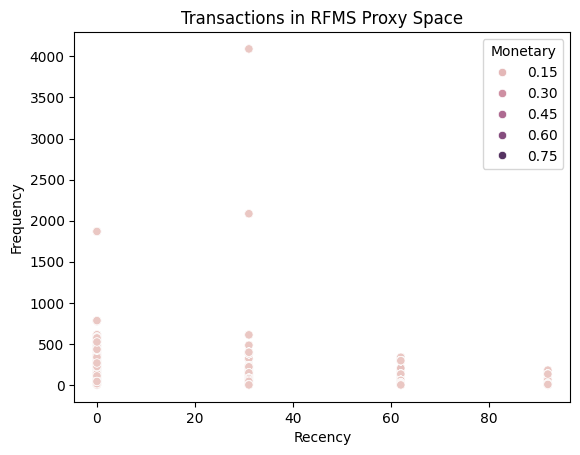

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=data, x='Recency', y='Frequency', hue='Monetary')
plt.title('Transactions in RFMS Proxy Space')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

# Assign Good and Bad Labels

In [6]:
# Combine proxy measures into one score
data['RFMS_Score'] = data['Recency'] + data['Frequency'] + data['Monetary']
threshold = data['RFMS_Score'].median()
data['RFMS_Label'] = data['RFMS_Score'].apply(lambda x: 'good' if x > threshold else 'bad')

# Weight of Evidence (WoE) Binning

In [8]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

# Split data into features and target
X = data[['Amount']]  # Replace with relevant features
y = data['RFMS_Label']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply WoE binning
woe_encoder = ce.WOEEncoder(cols=['Amount'])  # Replace 'Amount' with relevant columns
X_train_woe = woe_encoder.fit_transform(X_train, y_train)
X_test_woe = woe_encoder.transform(X_test)

# Add the transformed columns back to your main data
data['Amount_woe'] = woe_encoder.transform(data[['Amount']])['Amount']


In [9]:
data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,...,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,Frequency,Monetary,TransactionDate,Recency,RFMS_Score,RFMS_Label,Amount_woe
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,256,ProviderId_6,ProductId_10,ChannelId_3,0.092004,...,0.0,0.0,0.0,119,0.091997,2018-11-01,0,119.091997,good,-0.004015
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,256,ProviderId_4,ProductId_6,ChannelId_2,0.091910,...,0.0,0.0,0.0,119,0.091997,2018-11-01,0,119.091997,good,0.001470
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,256,ProviderId_6,ProductId_1,ChannelId_3,0.091958,...,0.0,0.0,0.0,2,0.091958,2018-11-01,92,94.091958,bad,-0.021873
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,256,ProviderId_1,ProductId_21,ChannelId_3,0.093750,...,0.0,0.0,1.0,38,0.092465,2018-11-01,0,38.092465,bad,0.108598
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,256,ProviderId_4,ProductId_6,ChannelId_2,0.091853,...,0.0,0.0,0.0,38,0.092465,2018-11-01,0,38.092465,bad,0.069084
